Postsynaptic rate predicted by MF approx. = 14.160000004788467 Hz
time for sim =  4.744607925415039 s
Time-avg, trial-avg postsynaptic rate = 12.85 Hz


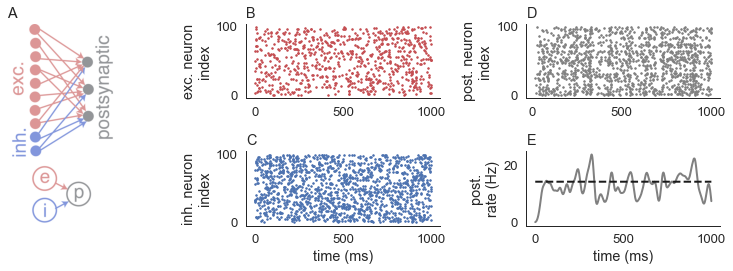

In [2]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

# Keep this set to false unless you want to save figures and data
# (in which case you'll need to change some directories below)
SaveFigures=False
###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(5)

# Discretized time
T=1000 
dt=.1 
time=np.arange(0,T,dt)

# Presynaptic rates summed across all
# presynaptic e and i neurons
re=8/1000
ri=15/1000

# Number of postsynaptic, exc, and inh neurons
N=100
Ne=2000
Ni=500

# Connection weights and probabilities
je=16
pe=0.1
ji=-16
pi=0.1


# Synapse parameters
Je=je*np.random.binomial(1,pe,(N,Ne))
Ji=ji*np.random.binomial(1,pi,(N,Ni))
taue=5
taui=5


# Neuron parameters
EL=-72 
taum=10
Vth=5
Vre=-75
VT=-55
D=2


# Stationary mean of Ie and Ii 
# from mean-field theory
we=je*pe*Ne
wi=ji*pi*Ni
IeBar=we*re
IiBar=wi*ri
IBar=IeBar+IiBar


# f-I curve fit from other file
data = np.load('./EIFfIcurve.npz',allow_pickle=True)
g=data['gfit']
theta=data['thetafit']
def f(I):
    return g*(I-theta)*(I>theta)


# Mean firing rate predicted from MF theory
rBarMF=f(IBar)
print('Postsynaptic rate predicted by MF approx. =',1000*rBarMF,'Hz')

# Generate spike densities
Se=np.random.binomial(1,re*dt,(Ne,len(time)))/dt
Si=np.random.binomial(1,ri*dt,(Ni,len(time)))/dt


# Euler solver to compute Is and V
t0=tm()
Ie=np.zeros((N,len(time)))
Ii=np.zeros((N,len(time)))
V=np.zeros((N,len(time)))
S=np.zeros((N,len(time)))
V[:,0]=EL
for i in range(len(time)-1):

    # Euler step
    V[:,i+1]=V[:,i]+dt*(-(V[:,i]-EL)+D*np.exp((V[:,i]-VT)/D)+Ie[:,i]+Ii[:,i])/taum 
    Ie[:,i+1]=Ie[:,i]+dt*(-Ie[:,i]+Je@Se[:,i])/taue
    Ii[:,i+1]=Ii[:,i]+dt*(-Ii[:,i]+Ji@Si[:,i])/taui
    
    # Threshold-reset condition
    Inds=np.where(V[:,i+1]>=Vth)
    V[Inds,i+1]=Vre 
    V[Inds,i]=Vth  # This makes plots nicer
    S[Inds,i+1]=1/dt
print('time for sim = ',tm()-t0,'s')
    
# Extract spike times and trial numbers
[I,J]=np.nonzero(Se)
eSpikeTimes=J*dt
eNeuronNumbers=I 
[I,J]=np.nonzero(Si)
iSpikeTimes=J*dt
iNeuronNumbers=I 
[I,J]=np.nonzero(S)
SpikeTimes=J*dt
NeuronNumbers=I 

# Time-averaged, trial-averaged rate
rBar=np.mean(S)
print('Time-avg, trial-avg postsynaptic rate =',1000*rBar,'Hz')

# Compute a smoothed trial-averaged rate
# by convolving the mean of S with a kernel
sigma=10
s=np.arange(-3*sigma,3*sigma,dt)
k=np.exp(-(s**2)/(2*sigma**2))
k=k/(sum(k)*dt)
SmoothedRate=np.convolve(k,np.mean(S,axis=0),'same')*dt




# Make figure
plt.subplots(figsize=(11, 4))

NumToPlot=100

plt.subplot(1,3,1)
im = plt.imread('FeedFwdNet.png')
plt.imshow(im,interpolation='hanning')
plt.axis('off')
plt.title('A',loc='left')

plt.subplot(2,3,2)
plt.plot(eSpikeTimes[eNeuronNumbers<NumToPlot],eNeuronNumbers[eNeuronNumbers<NumToPlot],'r.',markersize=3)
#plt.xlabel('time (ms)')
plt.ylabel('exc. neuron\nindex')
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,5)
plt.plot(iSpikeTimes[iNeuronNumbers<NumToPlot],iNeuronNumbers[iNeuronNumbers<NumToPlot],'b.',markersize=3)
plt.xlabel('time (ms)')
plt.ylabel('inh. neuron\nindex')
plt.title('C',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(SpikeTimes[NeuronNumbers<NumToPlot],NeuronNumbers[NeuronNumbers<NumToPlot],'.',markersize=3,color='gray')
plt.ylabel('post. neuron\nindex')
plt.title('D',loc='left')
sns.despine()

plt.subplot(2,3,6)
plt.plot(time,1000*SmoothedRate,color='gray')
plt.plot(time,1000*rBarMF+np.zeros_like(time),'k--')
plt.xlabel('time (ms)')
plt.ylabel('post.\nrate (Hz)')
plt.title('E',loc='left')
sns.despine()


plt.tight_layout()

# Save figure if needed
if SaveFigures:
      plt.savefig('../Figures/FeedFwdNet.pdf')
